## Unique Characteristics: Random-effects coefficients from MixedLM model

In [1]:
import os
os.chdir("..")

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jenkspy import jenks_breaks
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA

from utils.Thesis_models import *
from utils import Thesis_viz as viz
from utils import synthetic_data_generation as sd

WARNING  [module_wrapper.py:149] From C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\tensorflow_probability\python\internal\backend\numpy\_utils.py:48: The name tf.logging.TaskLevelStatusMessage is deprecated. Please use tf.compat.v1.logging.TaskLevelStatusMessage instead.



WARNING  [module_wrapper.py:149] From C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\tensorflow_probability\python\internal\backend\numpy\_utils.py:48: The name tf.control_flow_v2_enabled is deprecated. Please use tf.compat.v1.control_flow_v2_enabled instead.

C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflo

WARNING  [module_wrapper.py:149] From C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\tf_utils.py:585: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.

WARNING  [optimizer.py:123] `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
WARNING  [optimizer.py:123] `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [3]:
def run_model(model, all_args):
    arg_names = model.__code__.co_varnames[:model.__code__.co_argcount]
    model_args = {k: all_args[k] for k in arg_names if k in all_args}
    return model(**model_args)

def get_reduced_data(label_df, column_break):
    
    zone_indices = {zone : list(label_df[label_df[column_break] == zone].index) \
                                                for zone in np.unique(label_df[column_break])}
    mapping_dict = {value: key for key, values in zone_indices.items() for value in values}
    data = df.copy()
    data['gE_new'] = df['gV'].map(mapping_dict)
    
    return data

### Synthetic data parameters

In [4]:
seed = 50
mode = 'both'
effective_groups = 5
visible_groups = 200
number_of_contineous_features = 5

# random_effects_distribution = 'normal'; re_intercept = (0,5) ; re_slope = (0,5)
random_effects_distribution = 'linspace'; re_intercept = (-10,10) ; re_slope = (-10,10)

# error_type = 'on_group' ; re_error = (0,3)
error_type = 'on_target' ; re_error = (0,3)

shuffle_groups = False

### Synthetic data generation

In [5]:
df,_ = sd.create_data(
    n = 1000,
    n_effective_groups = effective_groups,
    n_visible_groups = visible_groups,
    n_contineous_features = 5,
    mode = mode,
    fixed_slope = (0, 1),
    fixed_intercept = 0,
    fixed_error=(0, 1),
    random_effects_distribution = random_effects_distribution,
    re_intercept = (-10, 10),
    re_slope = (-10, 10),
    error_type = error_type,
    re_error = (0, 3),
    random_seed = seed,
    shuffle_groups = shuffle_groups,
    show_random_effects = False
)
df

,f0,f1,f2,f3,f4,gE,gV,y
0,-0.010797,-0.543834,-0.489052,-0.207340,-0.245370,0,0,-3.695253
1,0.993148,-0.183606,0.543788,0.521073,-0.379981,0,0,-23.659988
2,-0.306918,-0.296470,-0.709066,0.945329,0.818357,0,0,-16.675451
3,0.119914,-0.372819,0.776400,0.349146,-0.217825,0,0,-21.283745
4,0.014368,0.048207,0.856002,0.142746,0.336675,0,0,-17.754629
...,...,...,...,...,...,...,...,...
995,-0.033881,0.289258,-0.238024,-0.035100,-0.829667,4,199,-2.581987
996,-0.738472,0.534579,0.588378,0.741214,-0.074996,4,199,24.790728
997,-0.348035,0.139808,-0.035477,0.023636,0.497246,4,199,11.455646
998,-0.073908,-0.417275,0.667721,-0.814868,-0.946318,4,199,0.056477


### Choose a model

In [6]:
# [MixedLM, LMMNN, LinearOHE, MERForest, ARMED]
Model = MERForest

### Model Performance with Effective Groups and Visible Groups

In [7]:
mse_with_Effective_groups = run_model(Model, {'df': df,'mode':mode,'to_drop':'gV'})[0]
mse_with_Visible_groups = run_model(Model, {'df': df,'mode':mode,'to_drop':'gE'})[0]
print("MSE_Effective_groups: ", mse_with_Effective_groups)
print("MSE_Visible_groups: ", mse_with_Visible_groups)

MSE_Effective_groups:  21.420172332134083
MSE_Visible_groups:  25.983893423930105


### Fitting the entire data with MixedLM model to extract values of random intercepts and slopes

In [8]:
start = time.time()

In [9]:
md = sm.MixedLM.from_formula(f"y ~ {' + '.join([i for i in df.columns if i.startswith('f')])} + (1|gV)" \
                             ,df, groups = 'gV', re_formula='~'+'+'.join([i for i in df.columns if i.startswith('f')]))

mdf = md.fit()
mdf_re = pd.DataFrame([])
    
try:
    est_intercept = [((i+1)*mdf.fe_params['1 | gV']) + mdf.random_effects[i]['gV'] + mdf.fe_params[0] for i in mdf.random_effects.keys()]
    mdf_re['intercept'] = est_intercept

    for idx, f_i in enumerate([i for i in df.columns if i.startswith('f')]):
        
        est_slope = [mdf.fe_params[str(f_i)] + mdf.random_effects[i][str(f_i)] for i in range(len(mdf.random_effects))]
        mdf_re['slope_'+str(f_i)] = est_slope

except IndexError: pass
mdf_re

,intercept,slope_f0,slope_f1,slope_f2,slope_f3,slope_f4
0,-13.703433,-7.427863,-6.416320,-5.023164,-5.123188,-6.368313
1,-12.306418,-10.052139,-9.656587,-7.384227,-8.496074,-10.295505
2,-11.073614,-9.534257,-11.168254,-7.465568,-9.151842,-10.128658
3,-9.581223,-9.391318,-9.115964,-7.371156,-8.519261,-8.667586
4,-12.203168,-8.771748,-9.129694,-6.639612,-7.528994,-8.736393
...,...,...,...,...,...,...
195,12.389500,7.012991,6.833523,8.627855,9.731048,9.963408
196,11.769114,7.485312,8.608387,10.026620,10.917753,12.206511
197,12.399089,7.261529,7.442781,7.592910,10.726129,10.240587
198,13.660185,3.940614,5.595356,6.159540,7.617438,5.947615


### Clustering

### 1) Jenks Natural breaks

### Dimensionality reduction to 1-D for Jenks

In [10]:
X = np.array(mdf_re)

pca = PCA(n_components=1)
pca.fit(X)
X_transformed = pca.transform(X)
pca_df = pd.DataFrame(X_transformed, columns = [f'pca' for i in range(X_transformed.shape[1])])

In [11]:
# For how many clusters
Jenks_range = range(2,11)

In [12]:
for i in Jenks_range:
    
    array = np.array(X_transformed).reshape(len(X_transformed))
    bins = i
    try:
        pca_df['Jenks-'+str(bins)] = pd.cut(array,bins=jenks_breaks(array, bins), labels=range(bins) ,include_lowest=True, duplicates='drop')
    except ValueError: pass
pca_df

,pca,Jenks-2,Jenks-3,Jenks-4,Jenks-5,Jenks-6,Jenks-7,Jenks-8,Jenks-9,Jenks-10
0,19.563044,1,2,3,4,5,5,6,7,8
1,24.976063,1,2,3,4,5,6,7,8,9
2,24.963960,1,2,3,4,5,6,7,8,9
3,22.473630,1,2,3,4,5,5,6,7,8
4,22.917516,1,2,3,4,5,6,7,8,9
...,...,...,...,...,...,...,...,...,...,...
195,-21.581326,0,0,0,0,0,0,0,0,0
196,-24.073721,0,0,0,0,0,0,0,0,0
197,-22.063979,0,0,0,0,0,0,0,0,0
198,-17.122558,0,0,0,0,1,1,1,1,1


### Evaluating model performance on data with different Jenks-N breaks

In [13]:
res = pd.DataFrame([])

for itr, i in enumerate([col for col in pca_df.columns if col.startswith('J')]):
       
    reduced_df = get_reduced_data(pca_df, i)
    reduced_df.drop(['gE','gV'], axis=1, inplace=True)
    
    try:
        test_mse = run_model(Model, {'df': reduced_df,'mode':mode})[0]
        res.at[itr, 'name'] = i
        res.at[itr, 'test_mse'] = test_mse
        
    except np.linalg.LinAlgError: pass

In [14]:
res

,name,test_mse
0,Jenks-2,51.624236
1,Jenks-3,31.323167
2,Jenks-4,26.157154
3,Jenks-5,22.131690
4,Jenks-6,23.008066
5,Jenks-7,23.304566
6,Jenks-8,21.983231
7,Jenks-9,22.492814
8,Jenks-10,22.271621


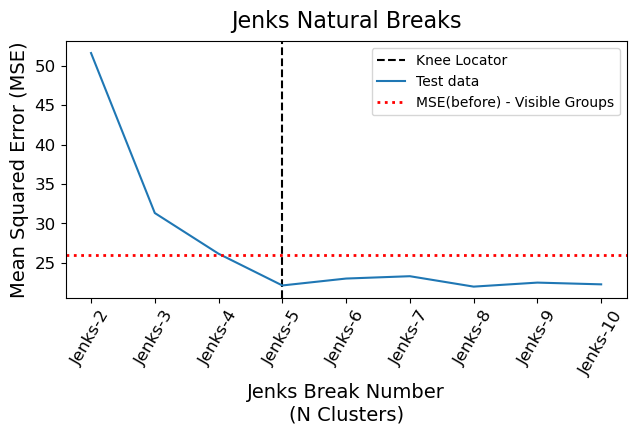

In [15]:
fig, ax = plt.subplots(figsize = (7,5), dpi = 100)
results = res.copy()
results.reset_index(drop=True, inplace=True)

try:
    kn = KneeLocator(results.index, results['test_mse'], curve='convex', direction='decreasing')
    plt.axvline(x=results[results.test_mse == kn.knee_y].index[0], color='k', linestyle='--', label='Knee Locator')
except ValueError: pass

ax.plot(results.name, results.test_mse,  label='Test data')

plt.axline((0, mse_with_Visible_groups), (1, mse_with_Visible_groups), color = 'r', ls=':', linewidth = 2, label = 'MSE(before) - Visible Groups')

plt.xticks(rotation=60)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend()
ax.set_title("Jenks Natural Breaks", fontsize = 16, y = 1.02)
ax.set_xlabel('Jenks Break Number\n(N Clusters)', fontsize = 14)
ax.set_ylabel("Mean Squared Error (MSE)", fontsize = 14)
plt.tight_layout(pad = 3)
plt.show()

In [16]:
end = time.time()
print("Time Took:",np.round((end-start),2))

Time Took: 28.12


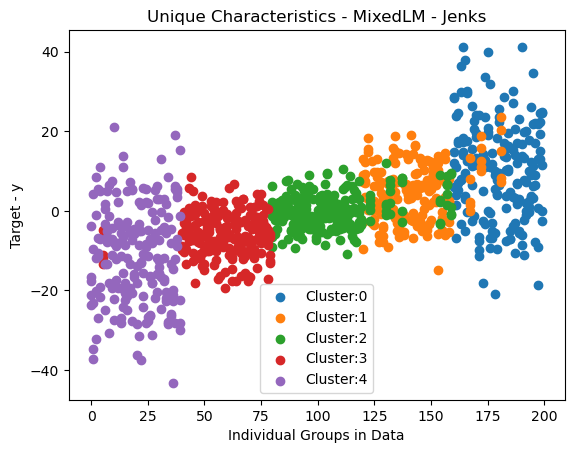

In [17]:
data = get_reduced_data(pca_df, 'Jenks-5')
for i in np.unique(data['gE_new']):
    sns.regplot(fit_reg=False,x = data[data['gE_new'] == i]['gV'], y = data[data['gE_new'] == i]['y'],label = "Cluster:"+str(i),scatter_kws={"alpha": 1})
plt.legend()
# plt.xticks(data.gV.unique())
plt.xlabel("Individual Groups in Data")
plt.ylabel("Target - y")
plt.title("Unique Characteristics - MixedLM - Jenks")
plt.show()

### 2) KMeans

In [18]:
X = np.array(mdf_re)
pca = PCA(n_components=2)
pca.fit(X)
X_transformed = pca.transform(X)
pca_df = pd.DataFrame(X_transformed, columns = [f'pca_'+str(i) for i in range(X_transformed.shape[1])])
X = np.array(pca_df)

K_range = range(2, 11)

for k in K_range:
    
    kmeans = KMeans(n_clusters= k, random_state=42)
    labels = kmeans.fit_predict(X)
    pca_df['K-'+str(k)] = labels

In [19]:
res = pd.DataFrame([])

for itr, i in enumerate([col for col in pca_df.columns if col.startswith('K')]):
       
    reduced_df = get_reduced_data(pca_df, i)
    reduced_df.drop(['gE','gV'], axis=1, inplace=True)
    
    try:
        test_mse = run_model(Model, {'df': reduced_df,'mode':mode})[0]
        res.at[itr, 'name'] = i
        res.at[itr, 'test_mse'] = test_mse
        
    except np.linalg.LinAlgError: pass

In [20]:
res

,name,test_mse
0,K-2,51.754969
1,K-3,31.398288
2,K-4,25.887199
3,K-5,22.922142
4,K-6,26.952629
5,K-7,23.988346
6,K-8,24.595083
7,K-9,29.545538
8,K-10,31.814121


In [21]:
end = time.time()
print("Time Took:",np.round((end-start),2))

Time Took: 45.68


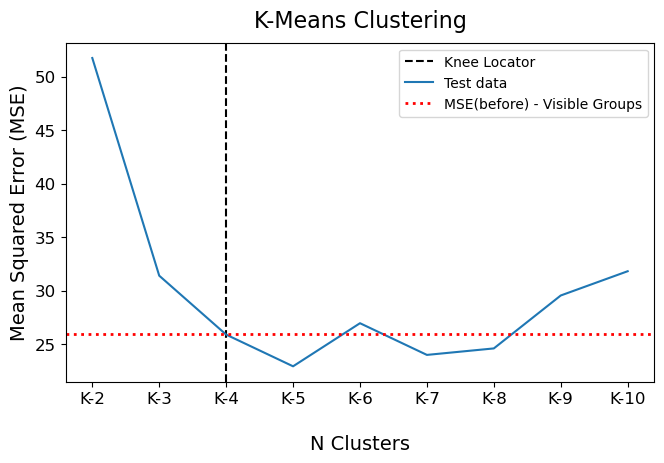

In [22]:
fig, ax = plt.subplots(figsize = (7,5), dpi = 100)
results = res.copy()
results.reset_index(drop=True, inplace=True)

try:
    kn = KneeLocator(results.index, results['test_mse'], curve='convex', direction='decreasing')
    plt.axvline(x=results[results.test_mse == kn.knee_y].index[0], color='k', linestyle='--', label='Knee Locator')
except ValueError: pass

ax.plot(results.name, results.test_mse,  label='Test data')
plt.axline((0, mse_with_Visible_groups), (1, mse_with_Visible_groups), color = 'r', ls=':', linewidth = 2, label = 'MSE(before) - Visible Groups')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend()
ax.set_title("K-Means Clustering", fontsize = 16, y = 1.02)
ax.set_xlabel('\nN Clusters', fontsize = 14)
ax.set_ylabel("Mean Squared Error (MSE)", fontsize = 14)
plt.tight_layout(pad = 2)
plt.show()

In [23]:
data = get_reduced_data(pca_df, 'K-4')
print("Clustered groups \n")

zone_indices_optics = {zone : list(np.unique(data[data['gE_new'] == zone]['gV'])) for zone in np.unique(data.gE_new)}
for i in np.unique(data.gE_new):
    print(i," : ",zone_indices_optics[i],'\n')

Clustered groups 

0  :  [5, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79] 

1  :  [127, 143, 146, 155, 156, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] 

2  :  [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 

3  :  [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 159] 



In [24]:
print("Original Group Memberships \n")
zone_indices_actual = {zone : list(np.unique(df[df['gE'] == zone]['gV'])) for zone in np.unique(df.gE)}
for i in np.unique(df.gE):
    print(i," : ",zone_indices_actual[i],'\n')

Original Group Memberships 

0  :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 

1  :  [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79] 

2  :  [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119] 

3  :  [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159] 

4  :  [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] 



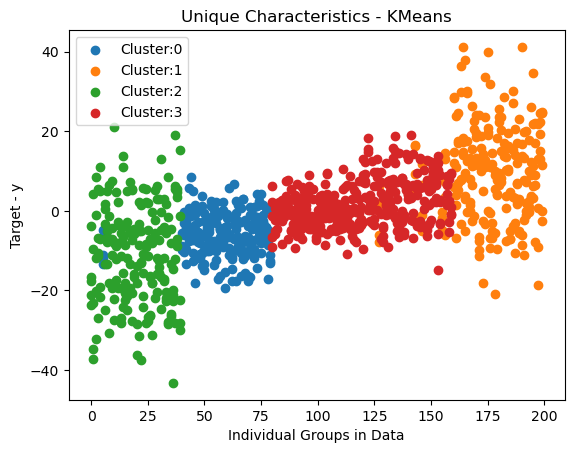

In [25]:
data = get_reduced_data(pca_df, 'K-4')
for i in np.unique(data['gE_new']):
    sns.regplot(fit_reg=False,x = data[data['gE_new'] == i]['gV'], y = data[data['gE_new'] == i]['y'],label = "Cluster:"+str(i),scatter_kws={"alpha": 1})
plt.legend()
# plt.xticks(data.gV.unique())
plt.xlabel("Individual Groups in Data")
plt.ylabel("Target - y")
plt.title("Unique Characteristics - KMeans")
plt.show()

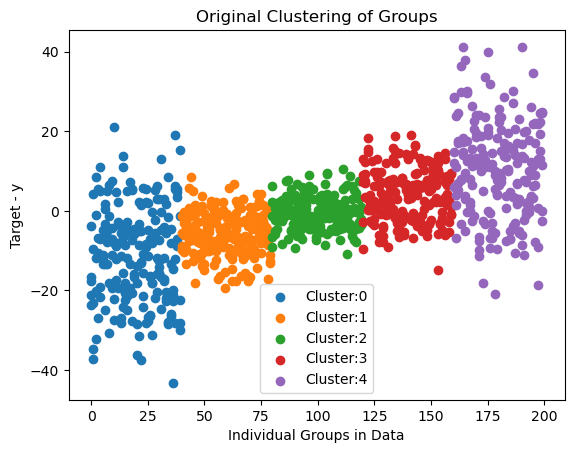

In [26]:
for i in np.unique(df['gE']):
    sns.regplot(fit_reg=False,x = df[df['gE'] == i]['gV'], y = df[df['gE'] == i]['y'],label = "Cluster:"+str(i),scatter_kws={"alpha": 1})
plt.legend()
plt.xlabel("Individual Groups in Data")
plt.ylabel("Target - y")
plt.title("Original Clustering of Groups")
plt.show()